# <center>Article tags perdictor

### Description 
This data is from a website https://medium.com/, looking for published articles. 

### Problem Statemtent
    Suggest the tags based on the content that was there in the articles. So as to benefit and suggest readers based on the gener they like to read.

### Data Source
https://www.kaggle.com/datasets/f0e6906affff324e5fc0bd1ca997c701b3ba4dd3aee1761bff9743153f707f64

### Real world / Bussiness Objective and constraints
1. Predicts tags appropriately with high precision and recall.
2. Incorrect tags could impact the customer experience.
3. No strict latency constraints.

### Mapping to ML problem
1. Since we can have multiple labels for a single article it is a Multi-label classification problem.

### Performance metric
    1. Micro-average F1-score<br>
    2. Hamming loss

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from datetime import timezone

from wordcloud import WordCloud

from sqlalchemy import create_engine # database connection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from nltk.stem import PorterStemmer

from sklearn.multiclass import OneVsRestClassifier
import joblib

import re
import os
import sqlite3
import csv

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load data and cleaning it
# To read a large csv file with pandas, we use chunksize attribute
if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    chunksize = 150000
    j = 0
    index_start = 1
    for df in pd.read_csv("medium_articles.csv", names = ['title','text','url','authors','timestamp','tags'],chunksize=chunksize,iterator=True,encoding = 'utf-8'):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data',disk_engine, if_exists = 'append')
        index_start = df.index[-1]+1

In [3]:
# counting number of rows
con = sqlite3.connect('train.db')
num_rows = pd.read_sql_query("""select count(*) as cnt from data""",con)
print("Number of rows in the database :",num_rows['cnt'].values[0])
con.close()

Number of rows in the database : 192369


In [4]:
# duplicate rows
con = sqlite3.connect('train.db')
df_no_dup = pd.read_sql_query("""select title,text,authors,timestamp,tags, count(*) as cnt_dup from data group by title,text,authors,timestamp,tags""",con)
con.close()

In [5]:
num_rows['cnt'].values[0] - df_no_dup.shape[0]

44

In [6]:
# number of times each question appeared in our database
df_no_dup.cnt_dup.value_counts()

1    192302
2        19
8         2
9         1
4         1
Name: cnt_dup, dtype: int64

In [7]:
# count the number of tags in each article or rows
df_no_dup['tag_count'] = df_no_dup['tags'].apply(lambda x: len(x.replace("[","").replace("]","").replace("'","").replace("'","").strip().split(","))) 

In [8]:
df_no_dup.tag_count.value_counts()

5    145998
4     23321
3     14298
2      5541
1      3166
6         1
Name: tag_count, dtype: int64

In [9]:
# To remove tags that are not unicode encoded
def keepRow(a):
    for x in a:
        for i in x:
            if ord(i)>127:
                return False
    else:
        return True
    
df_no_dup['TagsC'] = df_no_dup.tags.apply(lambda x: x.replace("[","").replace("]","").replace("'","").replace("'","").strip())
df_no_dup.drop('tags',axis=1,inplace=True)

df_no_dup['keeprows'] = df_no_dup.TagsC.apply(lambda x: keepRow(x.split(',')))

In [10]:
df_no_dup = df_no_dup[(df_no_dup['keeprows']==True)]
df_no_dup.drop('keeprows',axis=1,inplace=True)

In [11]:
df_no_dup.shape

(190158, 7)

In [12]:
df_no_dup.head()

,title,text,authors,timestamp,cnt_dup,tag_count,TagsC
0,None,"Hi people, I’m coco. I am a roamer, a full-tim...",[],2020-12-27 09:28:24.998000+00:00,1,2,"Dreams, Nostalgia"
1,None,I am a product builder who specializes in prog...,[],2019-03-08 02:38:09.578000+00:00,1,1,Life
2,None,I am a product builder who specializes in prog...,[],2020-12-24 13:35:06.513000+00:00,1,2,"Politics, Life"
3,None,Learn more. Medium is an open platform where 1...,['Chokchai Phatharamalai'],2020-12-21 05:06:12.801000+00:00,1,4,"Jiggle, Moij Model, Facilitation, Coaching"
4,None,ในหนังสือ High Output Management หนังสือ manag...,"['ตง', 'วรพล ร ตนพ นธ']",2019-02-19 00:57:27.024000+00:00,1,3,"New Ways Of Working, Management, Productivity"


In [13]:
#Creating a new database with no duplicates
if not os.path.isfile('train_no_dup.db'):
    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns = ['title','text','authors','timestamp','TagsC'])
    no_dup.to_sql('no_dup_train',disk_dup)

In [14]:
con = sqlite3.connect('train_no_dup.db')
tag_data = pd.read_sql_query("""select TagsC from no_dup_train""",con)
con.close()

tag_data.head()

,TagsC
0,"Dreams, Nostalgia"
1,Life
2,"Politics, Life"
3,"Jiggle, Moij Model, Facilitation, Coaching"
4,"New Ways Of Working, Management, Productivity"


# Analysis of Tags

In [15]:
# Total number of unique tags
# BOW 
vectorizer = CountVectorizer(tokenizer= lambda x: x.split(","))
tag_dtm = vectorizer.fit_transform(tag_data['TagsC'])

print("Number of data points :", tag_dtm.shape[0])
print('Number of unique tags :', tag_dtm.shape[1])

Number of data points : 190158
Number of unique tags : 93013


In [16]:
tags = vectorizer.get_feature_names()
print("Some of the tags we have :",tags[20:30])

Some of the tags we have : [' 10 things', ' 10 usd a day', ' 100', ' 100 days', ' 100 days writing', ' 100 naked words', ' 100 percent renewable', ' 100 words', ' 100 words project', ' 10000 push ups']


In [17]:
# Number of times a tag appeared
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags,freqs))

In [18]:
# Saving this dict into csv
if not os.path.isfile("tag/tag_counts_dict_dtm.csv"):
    with open('tag/tag_counts_dict_dtm.csv','w') as csv_file:    #creates a new file
        writer = csv.writer(csv_file)
        for k,v in result.items():
            writer.writerow([k,v])
tag_df = pd.read_csv("tag/tag_counts_dict_dtm.csv",names=['tags','counts'])
tag_df.head()

,tags,counts
0,NaN,1
1,first stories,1
2,friendship &/or words,1
3,north khorasan,1
4,0.11.5,1


In [19]:
tag_df_sorted = tag_df.sort_values(['counts'],ascending=False)
tag_counts = tag_df_sorted['counts'].values

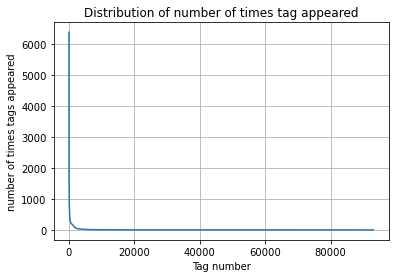

In [20]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared")
plt.grid()
plt.xlabel('Tag number')
plt.ylabel('number of times tags appeared')
plt.show()

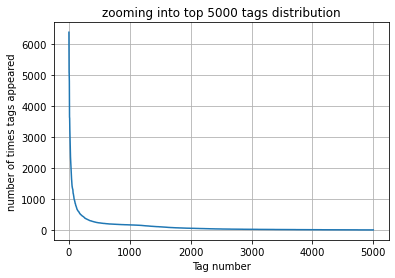

In [21]:
# zooming into top 5000 tags distribution
plt.plot(tag_counts[:5000])
plt.title("zooming into top 5000 tags distribution")
plt.grid()
plt.xlabel('Tag number')
plt.ylabel('number of times tags appeared')
plt.show()

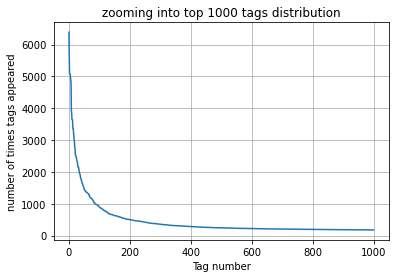

In [22]:
# zooming into top 1000 tags distribution
plt.plot(tag_counts[:1000])
plt.title("zooming into top 1000 tags distribution")
plt.grid()
plt.xlabel('Tag number')
plt.ylabel('number of times tags appeared')
plt.show()

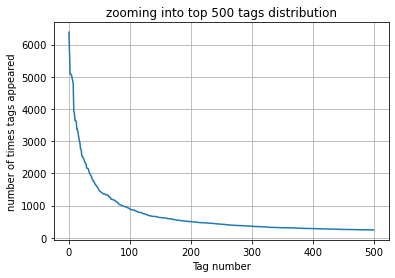

In [23]:
# zooming into top 500 tags distribution
plt.plot(tag_counts[:500])
plt.title("zooming into top 500 tags distribution")
plt.grid()
plt.xlabel('Tag number')
plt.ylabel('number of times tags appeared')
plt.show()

In [24]:
lst_tags_gt_1k = tag_df[tag_df.counts>1000].tags
print(len(lst_tags_gt_1k),"tags are more than 1k times")
lst_tags_gt_5k = tag_df[tag_df.counts>5000].tags
print(len(lst_tags_gt_5k),"tags are greater than 5k times")

88 tags are more than 1k times
5 tags are greater than 5k times


In [25]:
tag_df[(tag_df.counts == max(tag_df['counts']))]

,tags,counts
15197,data science,6385


In [26]:
# top 5 used tags in the dataset
tag_df_sorted.head()

,tags,counts
15197,data science,6385
7135,blockchain,5698
14138,cryptocurrency,5087
46309,programming,5082
34001,life,5070


In [27]:
# tags per question
tag_quest_count = tag_dtm.sum(axis=1).tolist()
tag_quest_count = [int(j) for i in tag_quest_count for j in i]
tag_quest_count[:5]

[2, 1, 2, 4, 3]

In [28]:
print("Max number of tags per question :",max(tag_quest_count))
print("Min number of tags per question :",min(tag_quest_count))
print("Avg number of tags per question :",(sum(tag_quest_count)/len(tag_quest_count)))

Max number of tags per question : 6
Min number of tags per question : 1
Avg number of tags per question : 4.577041197320123


<AxesSubplot:ylabel='count'>

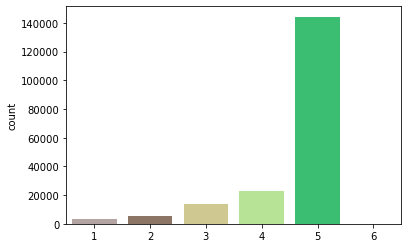

In [29]:
sns.countplot(tag_quest_count,palette="terrain_r")

In [30]:
tag_quest_count.count(6)

1

### Observations
1. Maximum number of tags per article is 6
2. Minimum number of tags per article is 1
3. Avg number of tags per article is 4.5
4. Only one article has 6 number of tags

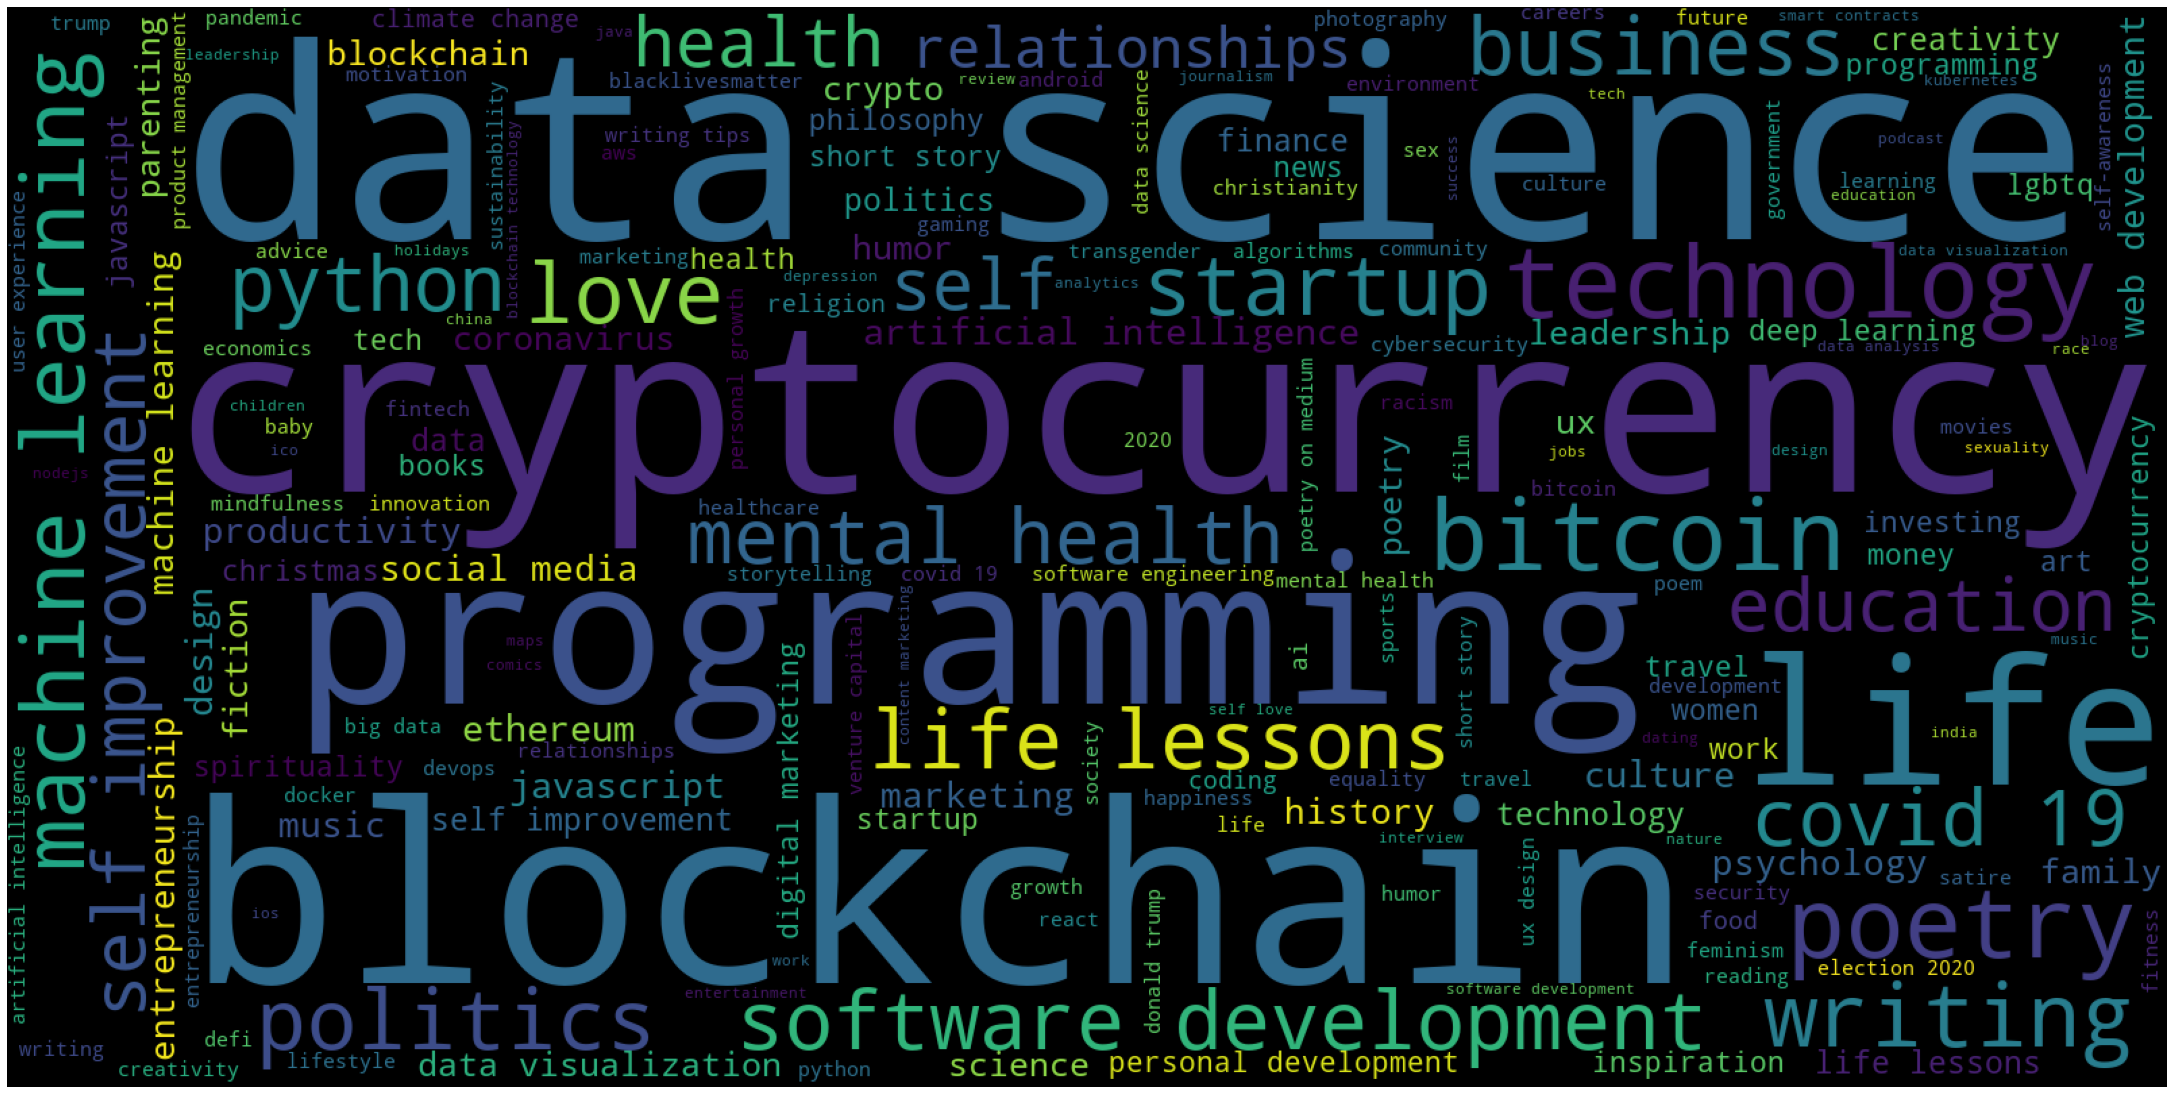

In [31]:
# Most frequent tags 
tup = dict(result.items())
wordcloud = WordCloud( background_color='black',
                     width = 1600,
                     height = 800,
                     ).generate_from_frequencies(tup)
fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

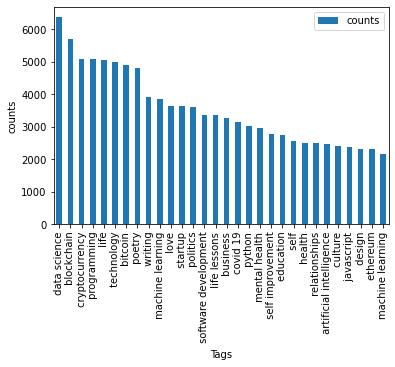

In [32]:
# the top 20 tags
i = np.arange(30)
a = tag_df_sorted['tags'][:30]
tag_df_sorted.head(30).plot(kind='bar')
plt.xticks(i,a)
plt.xlabel('Tags')
plt.ylabel('counts')
plt.show()

### Observations 
1. Most of the articles have technical domained tags 
2. Data Science is the most frequent tag.
3. BlockChain, cryptocurrency, programming are some of most frequent tags

## Cleaning and preprocessing the questions

In [33]:
df_no_dup.isna().sum().sum()

7

In [34]:
df_no_dup.dropna(inplace=True)

In [35]:
df_no_dup.shape

(190151, 7)

In [36]:
df_no_dup.head(2)

,title,text,authors,timestamp,cnt_dup,tag_count,TagsC
5,!!!world famous astrologer in canada!!!!+91–84...,[नाम और उम्र बताकर घर बैठे जीवन की हर समस्या क...,['Pandit Keshav'],2021-05-16 08:03:22.092000+00:00,1,5,"Los Angeles, London, Discord, Dubai, America"
6,"!!2021/𝐿𝐼𝒱𝐸⪼•”USA vs Russia(Livestream), TV ch...",Live Now:: https://tinyurl.com/y783azuc\n\nWat...,['Russia Vs Usa Live'],2020-12-25 21:24:48.106000+00:00,1,5,"Hd, Hockey, USA, Russia, Live"


# Cleaning the text data
1. puntuations, special characters and contractions
2. non english words
3. web-urls and phone number 
4. lower case letter
5. str len less than 3 
6. stemming

In [37]:
def remove_non_english(txt):
    # initalizing the stemmer from NLTK library 
    ps = PorterStemmer()
    
    # puntuations, special characters and contractions
    txt = txt.replace('\n'," ").replace("[","").replace("]","").replace("(","").replace(")","").replace("!","")\
    .replace(">","").replace("@","").replace("#","").replace("$","").replace("%","").replace("^","").replace("&","")\
    .replace("*","").replace("-","").replace("_","").replace("+","").replace("=","").replace("{","").replace("}","")\
    .replace(":","").replace("\"","").replace("'","").replace("'","").replace("?","").replace(",","").replace(".","")\
    .replace("/","").replace("|","").replace("~","").replace("`","").replace("'ve"," have").replace("'m"," am")\
    .replace("n't"," not").replace("'s"," is").replace("'d"," would").replace("'re"," are").replace("'ll"," will")\
    .replace("'","").replace("<","")
    
    # non english words (getting rid of hindi, japanese, chinese and other non english language text)
    # removing words with length less than 3
    # reremoving web-urls
    # converting text to lower-case
    # stemming each word
    eng_txt = ''
    for x in txt.split():
        if x.isalnum() and len(re.findall("[a-zA-Z0-9]",x))>2:
            word =''
            for z in x:
                if len(re.findall("[a-zA-Z0-9]",z))>0:
                    word +=z
        else:
            continue
        if word.startswith("http") or len(ps.stem(word))<3:
            continue
        
        eng_txt = eng_txt+" "+ps.stem(word.lower())
    
    return eng_txt

In [38]:
df_no_dup.head()

,title,text,authors,timestamp,cnt_dup,tag_count,TagsC
5,!!!world famous astrologer in canada!!!!+91–84...,[नाम और उम्र बताकर घर बैठे जीवन की हर समस्या क...,['Pandit Keshav'],2021-05-16 08:03:22.092000+00:00,1,5,"Los Angeles, London, Discord, Dubai, America"
6,"!!2021/𝐿𝐼𝒱𝐸⪼•”USA vs Russia(Livestream), TV ch...",Live Now:: https://tinyurl.com/y783azuc\n\nWat...,['Russia Vs Usa Live'],2020-12-25 21:24:48.106000+00:00,1,5,"Hd, Hockey, USA, Russia, Live"
7,!MY! Top 50 Albums of 2020,I put the emphasis on MY for a specific reason...,['Brandan Verrastro'],2020-12-23 15:21:26.325000+00:00,1,5,"Hip Hop, Rnb, Album Review, Lists, Pop"
8,!唐人街探案3! 「完整版」 [Detective Chinatown 3]高清电影[1080P],唐人街探案3 劇場版唐人街探案3 (2021)完整版 — 在线观看【唐人街探案3 劇場版】-...,['Kivli Ahli Coli'],2020-12-26 18:04:50.029000+00:00,1,5,"Comedy, Detective Chinatown 2, China, Full Ver..."
9,"""Brexit: The Uncivil War""","""Brexit: The Uncivil War""\n\nLast night I watc...",['Robert Oldershaw'],2020-12-14 19:50:28.464000+00:00,1,5,"Leadership, News, Brexit, Politics, Life"


In [39]:
df_no_dup['clean_text'] = df_no_dup.text.apply(lambda x: remove_non_english(x))

In [40]:
df_no_dup.head()

,title,text,authors,timestamp,cnt_dup,tag_count,TagsC,clean_text
5,!!!world famous astrologer in canada!!!!+91–84...,[नाम और उम्र बताकर घर बैठे जीवन की हर समस्या क...,['Pandit Keshav'],2021-05-16 08:03:22.092000+00:00,1,5,"Los Angeles, London, Discord, Dubai, America",astrolog pandit keshav get true solut for all...
6,"!!2021/𝐿𝐼𝒱𝐸⪼•”USA vs Russia(Livestream), TV ch...",Live Now:: https://tinyurl.com/y783azuc\n\nWat...,['Russia Vs Usa Live'],2020-12-25 21:24:48.106000+00:00,1,5,"Hd, Hockey, USA, Russia, Live",live now watch live direct inch closer christ...
7,!MY! Top 50 Albums of 2020,I put the emphasis on MY for a specific reason...,['Brandan Verrastro'],2020-12-23 15:21:26.325000+00:00,1,5,"Hip Hop, Rnb, Album Review, Lists, Pop",put the emphasi for specif reason need point ...
8,!唐人街探案3! 「完整版」 [Detective Chinatown 3]高清电影[1080P],唐人街探案3 劇場版唐人街探案3 (2021)完整版 — 在线观看【唐人街探案3 劇場版】-...,['Kivli Ahli Coli'],2020-12-26 18:04:50.029000+00:00,1,5,"Comedy, Detective Chinatown 2, China, Full Ver...",2021 2021 2021 chines english chines 136 baoq...
9,"""Brexit: The Uncivil War""","""Brexit: The Uncivil War""\n\nLast night I watc...",['Robert Oldershaw'],2020-12-14 19:50:28.464000+00:00,1,5,"Leadership, News, Brexit, Politics, Life",brexit the uncivil war last night watch that ...


In [41]:
df_no_dup.drop(['authors','text','cnt_dup','tag_count'],axis=1,inplace=True)

In [42]:
#df_no_dup.to_csv('clean_data.csv',index=False)

In [43]:
df_no_dup.head()

,title,timestamp,TagsC,clean_text
5,!!!world famous astrologer in canada!!!!+91–84...,2021-05-16 08:03:22.092000+00:00,"Los Angeles, London, Discord, Dubai, America",astrolog pandit keshav get true solut for all...
6,"!!2021/𝐿𝐼𝒱𝐸⪼•”USA vs Russia(Livestream), TV ch...",2020-12-25 21:24:48.106000+00:00,"Hd, Hockey, USA, Russia, Live",live now watch live direct inch closer christ...
7,!MY! Top 50 Albums of 2020,2020-12-23 15:21:26.325000+00:00,"Hip Hop, Rnb, Album Review, Lists, Pop",put the emphasi for specif reason need point ...
8,!唐人街探案3! 「完整版」 [Detective Chinatown 3]高清电影[1080P],2020-12-26 18:04:50.029000+00:00,"Comedy, Detective Chinatown 2, China, Full Ver...",2021 2021 2021 chines english chines 136 baoq...
9,"""Brexit: The Uncivil War""",2020-12-14 19:50:28.464000+00:00,"Leadership, News, Brexit, Politics, Life",brexit the uncivil war last night watch that ...


In [44]:
df_no_dup.shape

(190151, 4)

In [45]:
df_no_dup['clean_title'] = df_no_dup.title.apply(lambda x: remove_non_english(x))

In [47]:
df_no_dup.drop('title',axis=1,inplace=True)
#df_no_dup.to_csv('preprocesed_data.csv',index=False)

In [82]:
#reading the preprocesed data
df = pd.read_csv("preprocesed_data.csv")
df.head()

,timestamp,TagsC,clean_text,clean_title
0,2021-05-16 08:03:22.092000+00:00,"Los Angeles, London, Discord, Dubai, America",astrolog pandit keshav get true solut for all...,world famou astrolog
1,2020-12-25 21:24:48.106000+00:00,"Hd, Hockey, USA, Russia, Live",live now watch live direct inch closer christ...,russialivestream channel2021
2,2020-12-23 15:21:26.325000+00:00,"Hip Hop, Rnb, Album Review, Lists, Pop",put the emphasi for specif reason need point ...,top album 2020
3,2020-12-26 18:04:50.029000+00:00,"Comedy, Detective Chinatown 2, China, Full Ver...",2021 2021 2021 chines english chines 136 baoq...,detect chinatown 31080p
4,2020-12-14 19:50:28.464000+00:00,"Leadership, News, Brexit, Politics, Life",brexit the uncivil war last night watch that ...,brexit the uncivil war


In [83]:
df.shape

(190151, 4)

# <CENTER>Data preparation 
<CENTER><b>Handling multilabel problem and converting as below.
<br>
<img src="multilabel.png" alt="Alternative text" width=150/>

In [4]:
vectorizer = CountVectorizer(tokenizer= lambda x: x.split(","),binary='true')
multilabel_y = vectorizer.fit_transform(df['TagsC'])

In [8]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x = multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [6]:
questions_explained = []
total_tags = multilabel_y.shape[1]
total_qs = df.shape[0]
for i in range(500,total_tags,100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

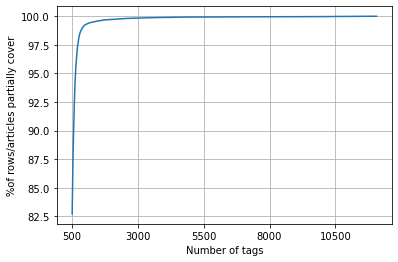

In [7]:
fig,ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("%of rows/articles partially cover")
plt.grid()
plt.show()

In [8]:
print("with ",700,"tags we are covering ",questions_explained[700],"% of articles/rows")

with  700 tags we are covering  99.963 % of articles/rows


In [9]:
multilabel_yx = tags_to_choose(700)
print("number of questions that are not covered :",questions_explained_fn(700),"out of ",total_qs)

number of questions that are not covered : 25392 out of  190151


In [10]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 93010
number of tags taken : 700 ( 0.7526072465326309 %)


## Split the data into test and train (80:20) 

In [84]:
def utcConvertor(row):
    row = row.split("+")[0]
    try:
        if '.' in row:
            date_time = datetime.strptime(row, '%Y-%m-%d %H:%M:%S.%f')
        else:
            date_time = datetime.strptime(row, '%Y-%m-%d %H:%M:%S')
        # get UTC timestamp
        utc_timestamp = date_time.replace(tzinfo=timezone.utc).timestamp()
    except:
        return np.nan
    return utc_timestamp

In [85]:
df['utctimestamp'] = df.timestamp.apply(lambda x : utcConvertor(x))

In [86]:
print(df.isna().sum().sum())
df.dropna(inplace=True)

991


In [87]:
df.drop('timestamp',axis=1,inplace=True)

In [88]:
df.head()

,TagsC,clean_text,clean_title,utctimestamp
0,"Los Angeles, London, Discord, Dubai, America",astrolog pandit keshav get true solut for all...,world famou astrolog,1.621152e+09
1,"Hd, Hockey, USA, Russia, Live",live now watch live direct inch closer christ...,russialivestream channel2021,1.608931e+09
2,"Hip Hop, Rnb, Album Review, Lists, Pop",put the emphasi for specif reason need point ...,top album 2020,1.608737e+09
3,"Comedy, Detective Chinatown 2, China, Full Ver...",2021 2021 2021 chines english chines 136 baoq...,detect chinatown 31080p,1.609006e+09
4,"Leadership, News, Brexit, Politics, Life",brexit the uncivil war last night watch that ...,brexit the uncivil war,1.607975e+09


In [89]:
#sorting the dataframe based on utc timestamp, so to perform time based splitting 
df = df.sort_values(by=['utctimestamp'])
df.head()

,TagsC,clean_text,clean_title,utctimestamp
126706,"Movies, Film, Existentialism, Philosophy, Culture",nihil can anyon truli alon throughout the maj...,sam 1917 and philosophi,-1.641082e+09
14409,"Fatherhood, Mothers, Family",mountain view 2000 septemb 2013 dear mom just...,letter mom jane steel april 1941sept 2003,-8.925120e+08
177600,"1969, History, Mwc Reentry, Hippies, Baby Boomers",whi quentin tarantino understand 1969 and hip...,whi quentin tarantino understand 1969 and hippi,-9.158400e+06
152709,"Queen, Charity, Live Aid, Bohemian Rhapsody, W12",the live aid festiv took place juli 1985 and ...,the fund rais dure the live aid chariti festi...,4.733856e+08
116928,"Review, Culture, Retro Gaming, Japanese Cultur...",play japanes teenag 1987 and aveng your murde...,play japanes teenag 1987 and aveng your murder,5.364576e+08


In [90]:
# Train-Test split
df.drop('utctimestamp',axis=1,inplace=True)

vectorizer = CountVectorizer(tokenizer= lambda x: x.split(","),binary='true')
multilabel_y = vectorizer.fit_transform(df['TagsC'])

multilabel_yx = tags_to_choose(700)

In [18]:
# 80 - 20 split
x_train = df.head(151328)
x_test = df.tail(37832)

y_train = multilabel_yx[0:151328,:]
y_test = multilabel_yx[151328:,:]

In [19]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (151328, 700)
Number of data points in test data : (37832, 700)


## Featurizing the text column

In [25]:
%%time
vectorizer = TfidfVectorizer(min_df=0.0009, max_features=200000,tokenizer=lambda x: x.split(),ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['clean_text'])
x_test_multilabel = vectorizer.transform(x_test['clean_text'])

CPU times: total: 13min 5s
Wall time: 23min 31s


In [26]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (151328, 99121) Y : (151328, 700)
Dimensions of test data X: (37832, 99121) Y: (37832, 700)


### Logistic Regression with OneVsRest classifier

In [35]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log',alpha=0.00001,penalty='l1'),n_jobs=-1)
classifier.fit(x_train_multilabel,y_train)
predictions = classifier.predict(x_test_multilabel)

In [36]:
print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("micro f1 score :",metrics.f1_score(y_test,predictions, average = 'micro'))
print("presicion recall report :\n",metrics.classification_report(y_test,predictions))

accuracy : 0.19124021991964474
micro f1 score : 0.16990501904440483
presicion recall report :
               precision    recall  f1-score   support

           0       0.43      0.35      0.38       907
           1       0.34      0.30      0.32       791
           2       0.41      0.11      0.17       624
           3       0.36      0.23      0.28       780
           4       0.38      0.01      0.02       631
           5       0.29      0.02      0.03       802
           6       0.48      0.45      0.46       478
           7       0.49      0.21      0.29       400
           8       0.54      0.22      0.31       492
           9       0.54      0.24      0.33       682
          10       0.39      0.14      0.21       527
          11       0.42      0.17      0.24       483
          12       0.42      0.13      0.20       425
          13       0.35      0.08      0.13       447
          14       0.33      0.01      0.02       467
          15       0.32      0.02      0

In [37]:
joblib.dump(classifier, 'lr_with_equal_weight.pkl') 

['lr_with_equal_weight.pkl']

In [95]:
df["combined"] = df['clean_text'] + " "+df["clean_title"]+ " "+df["clean_title"]+ " "+df["clean_title"]

In [97]:
df.drop(['clean_text','clean_title'],axis=1,inplace=True)

In [98]:
df.head()

,TagsC,combined
126706,"Movies, Film, Existentialism, Philosophy, Culture",nihil can anyon truli alon throughout the maj...
14409,"Fatherhood, Mothers, Family",mountain view 2000 septemb 2013 dear mom just...
177600,"1969, History, Mwc Reentry, Hippies, Baby Boomers",whi quentin tarantino understand 1969 and hip...
152709,"Queen, Charity, Live Aid, Bohemian Rhapsody, W12",the live aid festiv took place juli 1985 and ...
116928,"Review, Culture, Retro Gaming, Japanese Cultur...",play japanes teenag 1987 and aveng your murde...


In [103]:
df.to_csv("final_data.csv",index=False)
df.to_csv("final_data_index.csv")

In [2]:
df_final = pd.read_csv("final_data.csv")
df_final.head()

,TagsC,combined
0,"Movies, Film, Existentialism, Philosophy, Culture",nihil can anyon truli alon throughout the maj...
1,"Fatherhood, Mothers, Family",mountain view 2000 septemb 2013 dear mom just...
2,"1969, History, Mwc Reentry, Hippies, Baby Boomers",whi quentin tarantino understand 1969 and hip...
3,"Queen, Charity, Live Aid, Bohemian Rhapsody, W12",the live aid festiv took place juli 1985 and ...
4,"Review, Culture, Retro Gaming, Japanese Cultur...",play japanes teenag 1987 and aveng your murde...


In [4]:
print("number of data points in sample :", df_final.shape[0])
print("number of dimensions :", df_final.shape[1])

number of data points in sample : 189160
number of dimensions : 2


In [5]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(","), binary='true')
multilabel_y = vectorizer.fit_transform(df_final['TagsC'])

In [14]:
# selecting 500 tags
questions_explained = []
total_tags = multilabel_y.shape[1]
total_qs = multilabel_y.shape[0]
for i in range(500, total_tags,100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

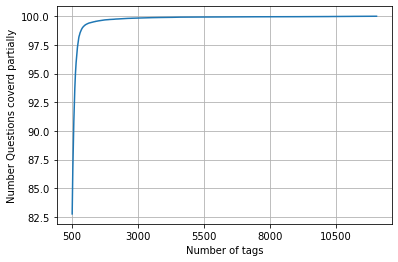

with  5500 tags we are covering  99.39 % of questions
with  900 tags we are covering  89.589 % of questions


In [19]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",900,"tags we are covering ",questions_explained[4],"% of questions")

In [20]:
multilabel_yx = tags_to_choose(900)

In [28]:
x_train=df_final.head(151328)
x_test=df_final.tail(37832)

y_train = multilabel_yx[0:151328,:]
y_test = multilabel_yx[151328:,:]

In [29]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (151328, 900)
Number of data points in test data : (37832, 900)


In [30]:
x_test.columns

Index(['TagsC', 'combined'], dtype='object')

In [32]:
# tf-idf vectorizing the combined column
vectorizer = TfidfVectorizer(min_df=0.0009, max_features=200000,tokenizer=lambda x: x.split(),ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['combined'])
x_test_multilabel = vectorizer.transform(x_test['combined'])

In [33]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (151328, 99700) Y : (151328, 900)
Dimensions of test data X: (37832, 99700) Y: (37832, 900)


In [34]:
#applying one vs rest logistic regression
classifier = OneVsRestClassifier(SGDClassifier(loss='log',alpha=0.00001,penalty='l1'),n_jobs=-1)
classifier.fit(x_train_multilabel,y_train)
predictions = classifier.predict(x_test_multilabel)
print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("micro f1 score :",metrics.f1_score(y_test,predictions, average = 'micro'))
print("presicion recall report :\n",metrics.classification_report(y_test,predictions))

accuracy : 0.1586223303023895
micro f1 score : 0.18200187010307062
presicion recall report :
               precision    recall  f1-score   support

           0       0.45      0.35      0.40       907
           1       0.34      0.33      0.33       791
           2       0.40      0.13      0.20       624
           3       0.38      0.19      0.25       780
           4       0.35      0.01      0.02       631
           5       0.32      0.02      0.04       802
           6       0.49      0.49      0.49       478
           7       0.47      0.18      0.26       400
           8       0.55      0.25      0.35       492
           9       0.54      0.27      0.36       682
          10       0.39      0.17      0.24       527
          11       0.43      0.18      0.25       483
          12       0.41      0.14      0.21       425
          13       0.38      0.09      0.15       447
          14       0.43      0.02      0.04       467
          15       0.33      0.02      0.